# Introduction
State notebook purpose here

### Imports
Import libraries and write settings here.

In [2]:
# Notebooks specific imports
from IPython import get_ipython
ipython = get_ipython()
#Expand notebook display
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))
# Display all cell outputs
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'
# autoreload extension
if 'autoreload' not in ipython.extension_manager.loaded:
    %load_ext autoreload
%autoreload 2
from tqdm.notebook import tqdm

# Basic useful imports
import re
import time
import yaml
from pprint import pprint
from pathlib import Path
import h5py
import gc
import pickle as pkl

import warnings
warnings.filterwarnings('ignore')

# Data manipulation
import numpy as np
from scipy.optimize import curve_fit
from scipy.special import erf, erfinv
from scipy.integrate import quad
from scipy.signal import savgol_filter
from scipy import fftpack
from scipy.stats import zmap
import torch
torch.__version__
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Torch device: {device}")

# Visualization
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.pylab as plb
from matplotlib.lines import Line2D
from matplotlib.patches import (Circle, RegularPolygon, FancyArrowPatch, ArrowStyle)
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,
                               AutoMinorLocator, NullFormatter)
import matplotlib.colors as mcolors
import matplotlib.colors as colors

# From alens_analysis.py
import alens_analysis as aa
from alens_analysis.colormaps import register_cmaps
import alens_analysis.chromatin as aac
import alens_analysis.chromatin.chrom_analysis as ca
import alens_analysis.chromatin.chrom_condensate_analysis as cca
import alens_analysis.chromatin.chrom_graph_funcs as cgf
from alens_analysis import cluster_analysis as cla

# Locations
ws_path = Path('/home/alamson/DATA/Chromatin/')
mnt_path = Path.home() / 'projects/DATA/Chromatin/'
ceph_path = Path.home() / 'ceph/DATA/Chromatin/'


# Style and graphing
from cond_char_style import cond_char_sty
plt.style.use(cond_char_sty)



Torch device: cuda


# Functions

In [3]:
def avg_dist_from_poly_com(com_arr):
    tcom_arr = torch.from_numpy(com_arr).to(device)
    pol_com = tcom_arr.mean(dim=0).to(device)
    tcom_dist = torch.norm(tcom_arr-pol_com, dim=1)
    tcom_dist_avg = torch.mean(tcom_dist,dim=1)
    return tcom_dist_avg

In [4]:
def poly_autocorr_fast(com_arr):
    # avg_rog = (aa.calc_rad_of_gyration(com_arr)).mean()
    tcom_arr = torch.from_numpy(com_arr).to(device)
    pol_com = tcom_arr.mean(dim=0).to(device)
    nsteps = tcom_arr.shape[-1]

    # Compute the FFT and then (from that) the auto-correlation function
    f = torch.fft.fftn(tcom_arr-pol_com, dim=[-1], norm='forward')
    power_spec = torch.einsum('ijk,ijk->ik', f, torch.conj(f))
    autocorr = torch.fft.ifftn(power_spec, norm='forward', dim=[-1])[:,:nsteps].real
    return autocorr.mean(dim=0)

def poly_rot_autocorr_fast(com_arr):
    tcom_arr = torch.from_numpy(com_arr).to(device)
    pol_com = tcom_arr.mean(dim=0).to(device)
    nsteps = tcom_arr.shape[-1]
    tdir_arr = tcom_arr-pol_com
    tdir_arr /= torch.norm(tdir_arr, dim=1)[:,None,:]

    # Compute the FFT and then (from that) the auto-correlation function
    f = torch.fft.fftn(tdir_arr, dim=[-1], norm='forward')
    power_spec = torch.einsum('ijk,ijk->ik', f, torch.conj(f))
    autocorr = torch.fft.ifftn(power_spec, norm='forward', dim=[-1])[:,:nsteps].real
    return autocorr.mean(dim=0)

def poly_dist_autocorr_fast(com_arr):
    tcom_arr = torch.from_numpy(com_arr).to(device)
    pol_com = tcom_arr.mean(dim=0).to(device)
    nsteps = tcom_arr.shape[-1]
    tcom_dist = torch.norm(tcom_arr-pol_com, dim=1)

    # Compute the FFT and then (from that) the auto-correlation function
    f = torch.fft.fftn(tcom_dist, dim=[-1], norm='forward')
    power_spec = torch.einsum('ik,ik->ik', f, torch.conj(f))
    autocorr = torch.fft.ifftn(power_spec, norm='forward', dim=[-1])[:,:nsteps].real
    return autocorr.mean(dim=0)

        

In [5]:
def autocorr_dist_graph_func_ci(fig, ax, data_path, param_str, label_str,
                           ci_bound=.95,
                           ss_ind=1,
                           end_ind=-2047,
                           start_bead=0,
                           end_bead=None):

    try:
        mp = re.compile(f'{param_str}(\d*\.?\d+)')

        param_dirs = sorted(
            [pd for pd in data_path.glob('*/')],
            key=lambda x: float(mp.match(str(x.name))[1]))

        param_vals = [float(mp.match(str(pd.name))[1]) for pd in param_dirs]
        log_pvs = np.log10(param_vals)
        log_pvs = (log_pvs-log_pvs.min())/((log_pvs.max() - log_pvs.min()))
        colors = plb.cm.plasma(log_pvs)

        avg_auto_corr_list = []
        std_auto_corr_list = []
        for i, pd in tqdm(enumerate(param_dirs)):
            auto_corr_list = []
            sd_h5_data_lst = [h5py.File(h5p, 'r+') for h5p in pd.glob('s*/analysis/raw*.h5')]
            if len(sd_h5_data_lst) == 0:
                continue

            for h5_data in sd_h5_data_lst:
                valid_n = int((-ss_ind+end_ind)/2)
                lag_arr = h5_data['time'][:valid_n]
                sy_dat = h5_data['raw_data']['sylinders'][start_bead:end_bead,
                                                        :, ss_ind:end_ind]
                com_arr = .5 * (sy_dat[:, 2:5, :] + sy_dat[:, 5:8, :])
                avg_dist = avg_dist_from_poly_com(com_arr)
                n_beads = com_arr.shape[0]
                auto_corr_list += [poly_dist_autocorr_fast(com_arr)[:valid_n]-(avg_dist.mean()**2)]
            min_length = min([len(avg) for avg in auto_corr_list])
            auto_corr_mat = torch.stack([avg[:min_length] for avg in auto_corr_list])
            
            avg_auto_corr_list += [auto_corr_mat.mean(dim=0).cpu()]
            std_auto_corr_list += [auto_corr_mat.std(dim=0).cpu()]
            
            label = re.split(r'(^[^\d]+)',str(pd.name))[1:][1]
            for h5d in sd_h5_data_lst:
                h5d.close()
        
            _ = ax.plot(lag_arr[:min_length], avg_auto_corr_list[-1], color=colors[i], label=f"{label_str}$= {label}$")
            ci = (std_auto_corr_list[-1]/np.sqrt(len(avg_auto_corr_list)))* (np.sqrt(2)*erfinv(ci_bound)) # confidence interval
            _ = ax.fill_between(lag_arr[:min_length], 
                                (avg_auto_corr_list[-1] - ci), (avg_auto_corr_list[-1] + ci),
                                color=colors[i], alpha=.25)

        _ = ax.set_ylabel('Autocorrelation ($\mu$m$^2$)\n' + r'$C_r - \langle |\Delta R_i| \rangle^2$')
        _ = ax.set_xlabel(r'Lag time $\tau$ (sec)')
        _ = ax.set_yscale('log')
        # _ = ax.set_ylim(0.0001)

        _ = ax.legend(loc='center left', bbox_to_anchor=(1.05, .5))
        fig.tight_layout()

    except:
        raise
    finally:
        for h5d in sd_h5_data_lst:
            h5d.close()
        pass

In [6]:
def autocorr_ang_graph_func_ci(fig, ax, data_path, param_str, label_str,
                           ci_bound=.95,
                           ss_ind=1,
                           end_ind=-2047,
                           start_bead=0,
                           end_bead=None):

    try:
        mp = re.compile(f'{param_str}(\d*\.?\d+)')

        param_dirs = sorted(
            [pd for pd in data_path.glob('*/')],
            key=lambda x: float(mp.match(str(x.name))[1]))
        param_vals = [float(mp.match(str(pd.name))[1]) for pd in param_dirs]

        log_pvs = np.log10(param_vals)
        log_pvs = (log_pvs-log_pvs.min())/((log_pvs.max() - log_pvs.min()))
        colors = plb.cm.plasma(log_pvs)
        avg_auto_corr_list = []
        std_auto_corr_list = []
        for i, pd in tqdm(enumerate(param_dirs)):
            auto_corr_list = []
            sd_h5_data_lst = [h5py.File(h5p, 'r+') for h5p in pd.glob('s*/analysis/raw*.h5')]
            if len(sd_h5_data_lst) == 0:
                continue

            for h5_data in sd_h5_data_lst:
                valid_n = int((-ss_ind+end_ind)/2)
                lag_arr = h5_data['time'][:valid_n]
                sy_dat = h5_data['raw_data']['sylinders'][start_bead:end_bead,
                                                        :, ss_ind:end_ind]
                com_arr = .5 * (sy_dat[:, 2:5, :] + sy_dat[:, 5:8, :])
                n_beads = com_arr.shape[0]
                auto_corr_list += [poly_rot_autocorr_fast(com_arr)[:valid_n]]
            min_length = min([len(avg) for avg in auto_corr_list])
            auto_corr_mat = torch.stack([avg[:min_length] for avg in auto_corr_list])
            
            avg_auto_corr_list += [auto_corr_mat.mean(dim=0).cpu()]
            std_auto_corr_list += [auto_corr_mat.std(dim=0).cpu()]
            
            label = re.split(r'(^[^\d]+)',str(pd.name))[1:][1]
            for h5d in sd_h5_data_lst:
                h5d.close()
        
            _ = ax.plot(lag_arr[:min_length], avg_auto_corr_list[-1], color=colors[i], label=f"{label_str}$= {label}$")
            ci = (std_auto_corr_list[-1]/np.sqrt(len(avg_auto_corr_list)))* (np.sqrt(2)*erfinv(ci_bound)) # confidence interval
            _ = ax.fill_between(lag_arr[:min_length], (avg_auto_corr_list[-1] - ci), (avg_auto_corr_list[-1] + ci),color=colors[i], alpha=.25)

        _ = ax.set_ylabel('Angular autocorrelation \n' + 
                          r'$C_a=\langle \hat{R}(t+\tau)\cdot\hat{R}(t)\rangle$')
        _ = ax.set_xlabel(r'Lag time $\tau$ (sec)')
        _ = ax.set_yscale('log')
        _ = ax.set_ylim(0.01)

        _ = ax.legend(loc='center left', bbox_to_anchor=(1.05, .5))
        fig.tight_layout()

    except:
        raise
    finally:
        for h5d in sd_h5_data_lst:
            h5d.close()

In [14]:
def monoExp(x, m, a):
    return m * np.exp(-a * x)

def negmonoExp(x, m, a):
    return m*(1. - np.exp(-a * x))

def line_func(x, a, b):
    return a*x + b

def fit_curve(x, y, fit_func):
    params, cv = curve_fit(fit_func, x, y)
    #print(params)
    squaredDiffs = np.square(y - fit_func(x, *params))
    squaredDiffsFromMean = np.square(y - np.mean(y))
    SEM = np.sqrt(np.sum(squaredDiffs))/x.size
    rSquared = 1 - np.sum(squaredDiffs) / np.sum(squaredDiffsFromMean)
    #print(f"R² = {rSquared}")

    return params, rSquared, SEM
def func_powerlaw(x, a, b, c):
    return a + b * np.power(x,c)

def func_powerlaw_zero(x, a, b, c):
    return b * np.power(x,c)

def rsqr_val(func, x, y, popts):
    residuals = y - func(x, *popts)
    ss_res = np.sum(residuals**2)
    ss_tot = np.sum((y-np.mean(y))**2)
    return 1. - (ss_res / ss_tot)

In [15]:
def find_steady_state_ind(arr, avg_inv=(0,None)):
    """Find the first time an array reaches an average value given an interval
    to average over (usually the end of the array).

    Parameters
    ----------
    arr : _type_
        _description_
    avg_inv : tuple, optional
        _description_, by default (0,None)
    """
    arr = np.array(arr)
    avg = arr[avg_inv[0]:avg_inv[1]].mean()
    if avg > arr[0]:
        return (arr >= avg).nonzero()[0]
    return (arr <= avg).nonzero()[0][0]



# Graphs

0it [00:00, ?it/s]

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


0it [00:00, ?it/s]

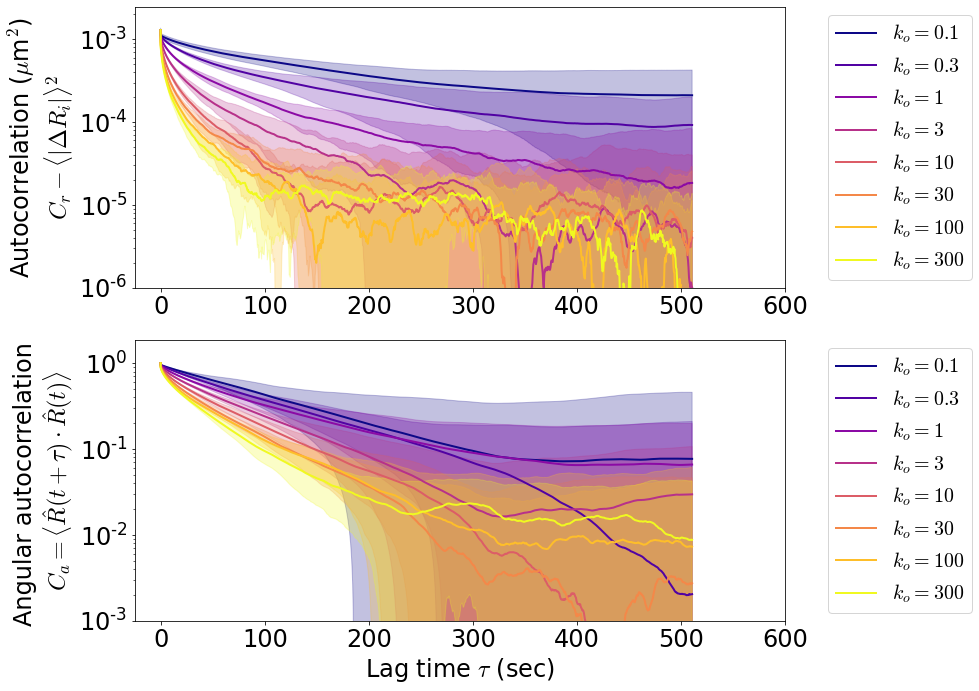

In [16]:
data_path = (ceph_path /"CondCharPaper/22-10-16_aLc1_line800_sticky55nm_kod.1-300/simulations")
fig, axarr = plt.subplots(2,1, figsize=(14, 10))
autocorr_dist_graph_func_ci(fig, axarr[0], data_path, "kod", "$k_o$",
                    ci_bound = .99,
                    ss_ind=-2047,
                    end_ind=-1,
                    start_bead=0,
                    end_bead=None,
                    )
_ = axarr[0].set_xlim(-25, 600)
_ = axarr[0].set_ylim(.1**6)
_ = axarr[0].set_xlabel('')
autocorr_ang_graph_func_ci(fig, axarr[1], data_path, "kod", "$k_o$",
                    ci_bound = .99,
                    ss_ind=-2047,
                    end_ind=-1,
                    start_bead=0,
                    end_bead=None,
                    )
    
_ = axarr[1].set_xlim(-25, 600)
_ = axarr[1].set_ylim(.1**3)
fig.tight_layout()

0it [00:00, ?it/s]

0it [00:00, ?it/s]

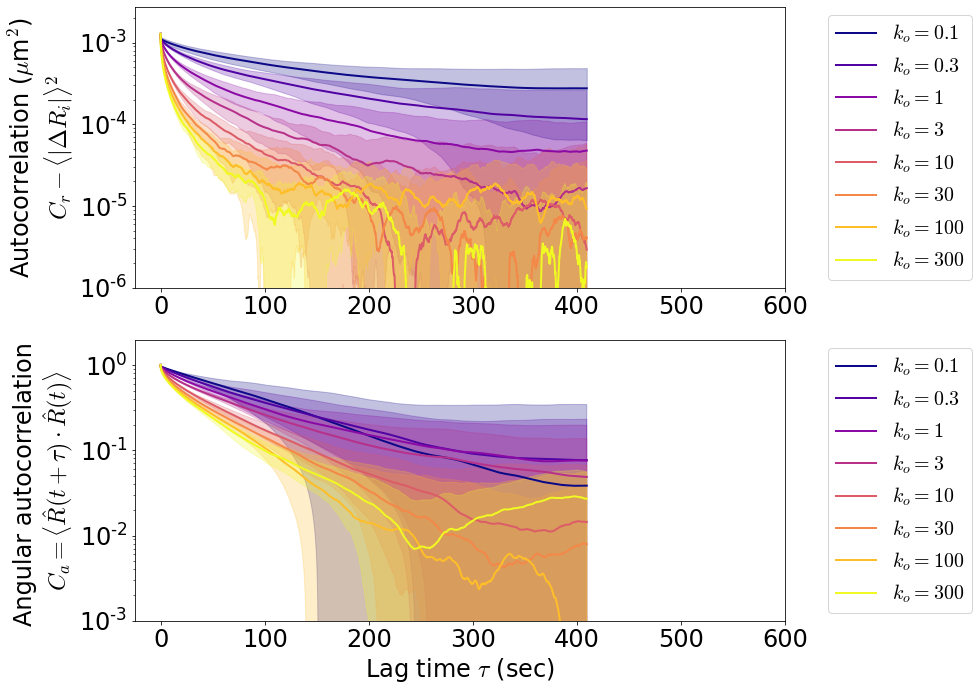

In [8]:
data_path = (ceph_path /"CondCharPaper/23-01-02_aLc1_line800_sticky55nm_kod.1-300_tsnap.1/simulations")
fig, axarr = plt.subplots(2,1, figsize=(14, 10))
autocorr_dist_graph_func_ci(fig, axarr[0], data_path, "kod", "$k_o$",
                    ci_bound = .99,
                    ss_ind=-8191,
                    end_ind=-1,
                    start_bead=0,
                    end_bead=None,
                    )
_ = axarr[0].set_xlim(-25, 600)
_ = axarr[0].set_ylim(.1**6)
_ = axarr[0].set_xlabel('')
autocorr_ang_graph_func_ci(fig, axarr[1], data_path, "kod", "$k_o$",
                    ci_bound = .99,
                    ss_ind=-8191,
                    end_ind=-1,
                    start_bead=0,
                    end_bead=None,
                    )
    
_ = axarr[1].set_xlim(-25, 600)
_ = axarr[1].set_ylim(.1**3)
fig.tight_layout()

# Test graphs

0it [00:00, ?it/s]

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


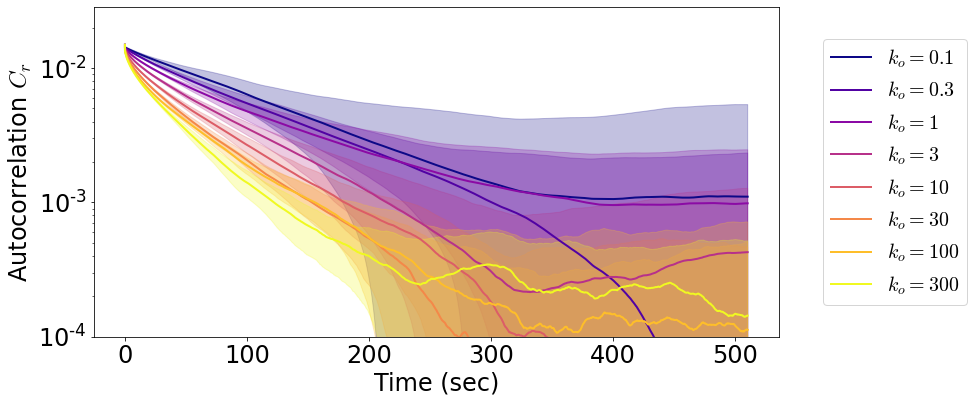

In [10]:
data_path = (ceph_path /"CondCharPaper/22-10-16_aLc1_line800_sticky55nm_kod.1-300/simulations")
ss_ind = -2047
end_ind = -1
start_bead = 0
end_bead = None
try:
    fig1, axarr1 = plt.subplots(1, 1, figsize=(14, 6))
    mp = re.compile('kod(\d*\.?\d+)')

    param_dirs = sorted([pd for pd in data_path.glob('*/')],key=lambda x: float(mp.match(str(x.name))[1]))
    param_vals = [float(mp.match(str(pd.name))[1]) for pd in param_dirs]
    log_pvs = np.log10(param_vals)
    log_pvs = (log_pvs-log_pvs.min())/((log_pvs.max() - log_pvs.min()))
    colors = pl.cm.plasma(log_pvs)
    avg_auto_corr_list = []
    std_auto_corr_list = []
    for i, pd in tqdm(enumerate(param_dirs)):
        auto_corr_list = []
        sd_h5_data_lst = [h5py.File(h5p, 'r+') for h5p in pd.glob('s*/analysis/raw*.h5')]
        if len(sd_h5_data_lst) == 0:
            continue

        for h5_data in sd_h5_data_lst:
            valid_n = int((-ss_ind+end_ind)/2)
            lag_arr = h5_data['time'][:valid_n]
            sy_dat = h5_data['raw_data']['sylinders'][start_bead:end_bead,
                                                      :, ss_ind:end_ind]
            com_arr = .5 * (sy_dat[:, 2:5, :] + sy_dat[:, 5:8, :])
            n_beads = com_arr.shape[0]
            auto_corr_list += [poly_autocorr_fast(com_arr)[:valid_n]]
        min_length = min([len(avg) for avg in auto_corr_list])
        auto_corr_mat = torch.stack([avg[:min_length] for avg in auto_corr_list])
        
        avg_auto_corr_list += [auto_corr_mat.mean(dim=0).cpu()]
        std_auto_corr_list += [auto_corr_mat.std(dim=0).cpu()]
        
        label = re.split(r'(^[^\d]+)',str(pd.name))[1:][1]
        for h5d in sd_h5_data_lst:
            h5d.close()
    
        _ = axarr1.plot(lag_arr[:min_length], avg_auto_corr_list[-1], color=colors[i], label=f"$ k_o = {label}$")
        ci = (std_auto_corr_list[-1]/np.sqrt(len(avg_auto_corr_list)))* (np.sqrt(2)*erfinv(.95)) # 95% confidence interval
        _ = axarr1.fill_between(lag_arr[:min_length], (avg_auto_corr_list[-1] - ci), (avg_auto_corr_list[-1] + ci),color=colors[i], alpha=.25)

    _ = axarr1.set_ylabel('Autocorrelation ' + r'$C_r$')
    _ = axarr1.set_xlabel('Time (sec)')
    _ = axarr1.set_xlabel('Time (sec)')
    _ = axarr1.set_yscale('log')
    _ = axarr1.set_ylim(0.0001)

    _ = axarr1.legend(loc='center left', bbox_to_anchor=(1.05, .5))
    fig1.tight_layout()

except:
    raise
finally:
    for h5d in sd_h5_data_lst:
        h5d.close()

0it [00:00, ?it/s]

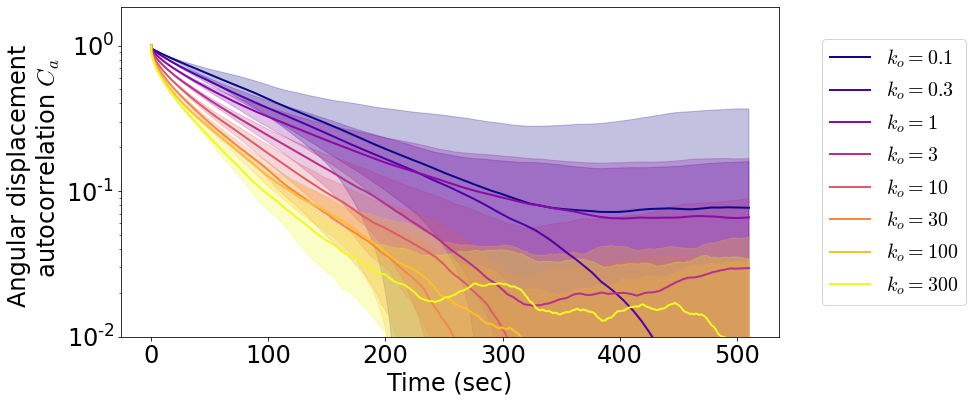

In [18]:
data_path = (ceph_path /"CondCharPaper/22-10-16_aLc1_line800_sticky55nm_kod.1-300/simulations")
ss_ind = -2047
end_ind = -1
start_bead = 0
end_bead = None
try:
    fig1, axarr1 = plt.subplots(1, 1, figsize=(14, 6))
    mp = re.compile('kod(\d*\.?\d+)')

    param_dirs = sorted([pd for pd in data_path.glob('*/')],key=lambda x: float(mp.match(str(x.name))[1]))
    param_vals = [float(mp.match(str(pd.name))[1]) for pd in param_dirs]
    log_pvs = np.log10(param_vals)
    log_pvs = (log_pvs-log_pvs.min())/((log_pvs.max() - log_pvs.min()))
    colors = pl.cm.plasma(log_pvs)
    avg_auto_corr_list = []
    std_auto_corr_list = []
    for i, pd in tqdm(enumerate(param_dirs)):
        auto_corr_list = []
        sd_h5_data_lst = [h5py.File(h5p, 'r+') for h5p in pd.glob('s*/analysis/raw*.h5')]
        if len(sd_h5_data_lst) == 0:
            continue

        for h5_data in sd_h5_data_lst:
            valid_n = int((-ss_ind+end_ind)/2)
            lag_arr = h5_data['time'][:valid_n]
            sy_dat = h5_data['raw_data']['sylinders'][start_bead:end_bead,
                                                      :, ss_ind:end_ind]
            com_arr = .5 * (sy_dat[:, 2:5, :] + sy_dat[:, 5:8, :])
            n_beads = com_arr.shape[0]
            auto_corr_list += [poly_rot_autocorr_fast(com_arr)[:valid_n]]
        min_length = min([len(avg) for avg in auto_corr_list])
        auto_corr_mat = torch.stack([avg[:min_length] for avg in auto_corr_list])
        
        avg_auto_corr_list += [auto_corr_mat.mean(dim=0).cpu()]
        std_auto_corr_list += [auto_corr_mat.std(dim=0).cpu()]
        
        label = re.split(r'(^[^\d]+)',str(pd.name))[1:][1]
        for h5d in sd_h5_data_lst:
            h5d.close()
    
        _ = axarr1.plot(lag_arr[:min_length], avg_auto_corr_list[-1], color=colors[i], label=f"$ k_o = {label}$")
        ci = (std_auto_corr_list[-1]/np.sqrt(len(avg_auto_corr_list)))* (np.sqrt(2)*erfinv(.95)) # 95% confidence interval
        _ = axarr1.fill_between(lag_arr[:min_length], (avg_auto_corr_list[-1] - ci), (avg_auto_corr_list[-1] + ci),color=colors[i], alpha=.25)

    _ = axarr1.set_ylabel('Angular displacement \n autocorrelation ' + r'$C_a$')
    _ = axarr1.set_xlabel('Time (sec)')
    _ = axarr1.set_xlabel('Time (sec)')
    _ = axarr1.set_yscale('log')
    _ = axarr1.set_ylim(0.01)

    _ = axarr1.legend(loc='center left', bbox_to_anchor=(1.05, .5))
    fig1.tight_layout()

except:
    raise
finally:
    for h5d in sd_h5_data_lst:
        h5d.close()

0it [00:00, ?it/s]

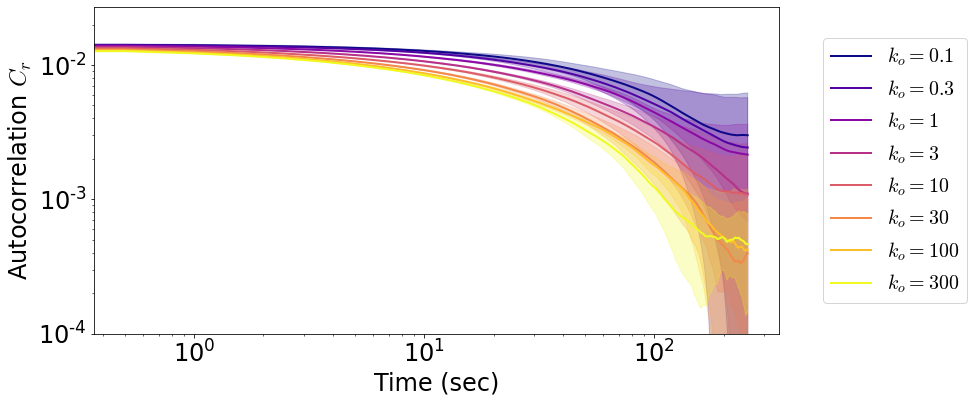

In [41]:
data_path = (ceph_path /"CondCharPaper/22-10-16_aLc1_line800_sticky55nm_kod.1-300/simulations")
ss_ind = -1023
end_ind = -1
start_bead = 0
end_bead = None
try:
    fig1, axarr1 = plt.subplots(1, 1, figsize=(14, 6))
    mp = re.compile('kod(\d*\.?\d+)')

    param_dirs = sorted([pd for pd in data_path.glob('*/')],key=lambda x: float(mp.match(str(x.name))[1]))
    param_vals = [float(mp.match(str(pd.name))[1]) for pd in param_dirs]
    log_pvs = np.log10(param_vals)
    log_pvs = (log_pvs-log_pvs.min())/((log_pvs.max() - log_pvs.min()))
    colors = pl.cm.plasma(log_pvs)
    avg_auto_corr_list = []
    std_auto_corr_list = []
    for i, pd in tqdm(enumerate(param_dirs)):
        auto_corr_list = []
        sd_h5_data_lst = [h5py.File(h5p, 'r+') for h5p in pd.glob('s*/analysis/raw*.h5')]
        if len(sd_h5_data_lst) == 0:
            continue

        for h5_data in sd_h5_data_lst:
            valid_n = int((-ss_ind+end_ind)/2)
            lag_arr = h5_data['time'][:valid_n]
            sy_dat = h5_data['raw_data']['sylinders'][start_bead:end_bead,
                                                      :, ss_ind:end_ind]
            com_arr = .5 * (sy_dat[:, 2:5, :] + sy_dat[:, 5:8, :])
            n_beads = com_arr.shape[0]
            auto_corr_list += [poly_autocorr_fast(com_arr)[:valid_n]]
        min_length = min([len(avg) for avg in auto_corr_list])
        auto_corr_mat = torch.stack([avg[:min_length] for avg in auto_corr_list])
        
        avg_auto_corr_list += [auto_corr_mat.mean(dim=0).cpu()]
        std_auto_corr_list += [auto_corr_mat.std(dim=0).cpu()]
        
        label = re.split(r'(^[^\d]+)',str(pd.name))[1:][1]
        for h5d in sd_h5_data_lst:
            h5d.close()
    
        _ = axarr1.plot(lag_arr[:min_length], avg_auto_corr_list[-1], color=colors[i], label=f"$ k_o = {label}$")
        ci = (std_auto_corr_list[-1]/np.sqrt(len(avg_auto_corr_list)))* (np.sqrt(2)*erfinv(.95)) # 95% confidence interval
        _ = axarr1.fill_between(lag_arr[:min_length], (avg_auto_corr_list[-1] - ci), (avg_auto_corr_list[-1] + ci),color=colors[i], alpha=.25)

    _ = axarr1.set_ylabel('Autocorrelation ' + r'$C_r$')
    _ = axarr1.set_xlabel('Time (sec)')
    _ = axarr1.set_xlabel('Time (sec)')
    _ = axarr1.set_yscale('log')
    _ = axarr1.set_xscale('log')
    _ = axarr1.set_ylim(0.0001)

    _ = axarr1.legend(loc='center left', bbox_to_anchor=(1.05, .5))
    fig1.tight_layout()

except:
    raise
finally:
    for h5d in sd_h5_data_lst:
        h5d.close()

0it [00:00, ?it/s]

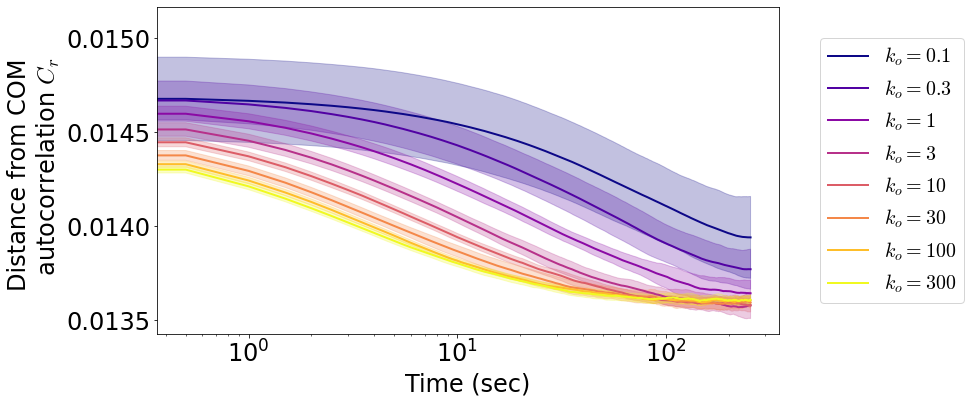

In [29]:
data_path = (ceph_path /"CondCharPaper/22-10-16_aLc1_line800_sticky55nm_kod.1-300/simulations")
ss_ind = -1023
end_ind = -1
start_bead = 0
end_bead = None
try:
    fig1, axarr1 = plt.subplots(1, 1, figsize=(14, 6))
    mp = re.compile('kod(\d*\.?\d+)')

    param_dirs = sorted([pd for pd in data_path.glob('*/')],key=lambda x: float(mp.match(str(x.name))[1]))
    param_vals = [float(mp.match(str(pd.name))[1]) for pd in param_dirs]
    log_pvs = np.log10(param_vals)
    log_pvs = (log_pvs-log_pvs.min())/((log_pvs.max() - log_pvs.min()))
    colors = pl.cm.plasma(log_pvs)
    avg_auto_corr_list = []
    std_auto_corr_list = []
    for i, pd in tqdm(enumerate(param_dirs)):
        auto_corr_list = []
        sd_h5_data_lst = [h5py.File(h5p, 'r+') for h5p in pd.glob('s*/analysis/raw*.h5')]
        if len(sd_h5_data_lst) == 0:
            continue

        for h5_data in sd_h5_data_lst:
            valid_n = int((-ss_ind+end_ind)/2)
            lag_arr = h5_data['time'][:valid_n]
            sy_dat = h5_data['raw_data']['sylinders'][start_bead:end_bead,
                                                      :, ss_ind:end_ind]
            com_arr = .5 * (sy_dat[:, 2:5, :] + sy_dat[:, 5:8, :])
            rog = aa.calc_rad_of_gyration(com_arr)
            n_beads = com_arr.shape[0]
            auto_corr_list += [poly_dist_autocorr_fast(com_arr)[:valid_n]]
        min_length = min([len(avg) for avg in auto_corr_list])
        auto_corr_mat = torch.stack([avg[:min_length] for avg in auto_corr_list])
        
        avg_auto_corr_list += [auto_corr_mat.mean(dim=0).cpu()]
        std_auto_corr_list += [auto_corr_mat.std(dim=0).cpu()]
        
        label = re.split(r'(^[^\d]+)',str(pd.name))[1:][1]
        for h5d in sd_h5_data_lst:
            h5d.close()
    
        _ = axarr1.plot(lag_arr[:min_length], avg_auto_corr_list[-1], color=colors[i], label=f"$ k_o = {label}$")
        ci = (std_auto_corr_list[-1]/np.sqrt(len(avg_auto_corr_list)))* (np.sqrt(2)*erfinv(.95)) # 95% confidence interval
        _ = axarr1.fill_between(lag_arr[:min_length], (avg_auto_corr_list[-1] - ci), (avg_auto_corr_list[-1] + ci),color=colors[i], alpha=.25)

    _ = axarr1.set_ylabel('Distance from COM \n autocorrelation ' + r'$C_r$')
    _ = axarr1.set_xlabel('Time (sec)')
    _ = axarr1.set_xlabel('Time (sec)')
    # _ = axarr1.set_yscale('log')
    _ = axarr1.set_xscale('log')
    # _ = axarr1.set_ylim(0.0001)

    _ = axarr1.legend(loc='center left', bbox_to_anchor=(1.05, .5))
    fig1.tight_layout()

except:
    raise
finally:
    for h5d in sd_h5_data_lst:
        h5d.close()

0it [00:00, ?it/s]

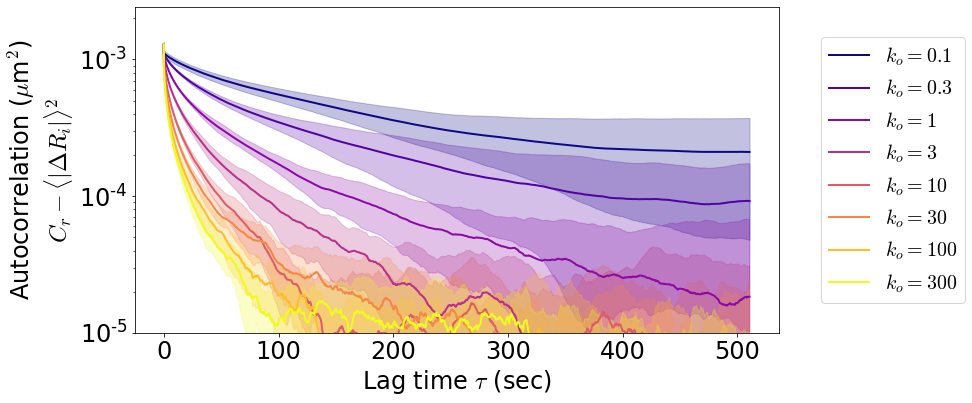

In [21]:
data_path = (ceph_path /"CondCharPaper/22-10-16_aLc1_line800_sticky55nm_kod.1-300/simulations")
ss_ind = -2047
end_ind = -1
start_bead = 0
end_bead = None
try:
    fig1, axarr1 = plt.subplots(1, 1, figsize=(14, 6))
    mp = re.compile('kod(\d*\.?\d+)')

    param_dirs = sorted([pd for pd in data_path.glob('*/')],key=lambda x: float(mp.match(str(x.name))[1]))
    param_vals = [float(mp.match(str(pd.name))[1]) for pd in param_dirs]
    log_pvs = np.log10(param_vals)
    log_pvs = (log_pvs-log_pvs.min())/((log_pvs.max() - log_pvs.min()))
    colors = pl.cm.plasma(log_pvs)
    avg_auto_corr_list = []
    std_auto_corr_list = []
    for i, pd in tqdm(enumerate(param_dirs)):
        auto_corr_list = []
        sd_h5_data_lst = [h5py.File(h5p, 'r+') for h5p in pd.glob('s*/analysis/raw*.h5')]
        if len(sd_h5_data_lst) == 0:
            continue

        for h5_data in sd_h5_data_lst:
            valid_n = int((-ss_ind+end_ind)/2)
            lag_arr = h5_data['time'][:valid_n]
            sy_dat = h5_data['raw_data']['sylinders'][start_bead:end_bead,
                                                      :, ss_ind:end_ind]
            com_arr = .5 * (sy_dat[:, 2:5, :] + sy_dat[:, 5:8, :])
            avg_dist = avg_dist_from_poly_com(com_arr)
            n_beads = com_arr.shape[0]
            auto_corr_list += [poly_dist_autocorr_fast(com_arr)[:valid_n]-(avg_dist.mean()**2)]
        min_length = min([len(avg) for avg in auto_corr_list])
        auto_corr_mat = torch.stack([avg[:min_length] for avg in auto_corr_list])
        
        avg_auto_corr_list += [auto_corr_mat.mean(dim=0).cpu()]
        std_auto_corr_list += [auto_corr_mat.std(dim=0).cpu()]
        
        label = re.split(r'(^[^\d]+)',str(pd.name))[1:][1]
        for h5d in sd_h5_data_lst:
            h5d.close()
    
        _ = axarr1.plot(lag_arr[:min_length], avg_auto_corr_list[-1], color=colors[i], label=f"$ k_o = {label}$")
        ci = (std_auto_corr_list[-1]/np.sqrt(len(avg_auto_corr_list)))* (np.sqrt(2)*erfinv(.95)) # 95% confidence interval
        _ = axarr1.fill_between(lag_arr[:min_length], (avg_auto_corr_list[-1] - ci), (avg_auto_corr_list[-1] + ci),color=colors[i], alpha=.25)

    _ = axarr1.set_ylabel('Autocorrelation ($\mu$m$^2$)\n' + r'$C_r - \langle |\Delta R_i| \rangle^2$')
    _ = axarr1.set_xlabel(r'Lag time $\tau$ (sec)')
    _ = axarr1.set_yscale('log')
    # _ = axarr1.set_xscale('log')
    _ = axarr1.set_ylim(0.00001)

    _ = axarr1.legend(loc='center left', bbox_to_anchor=(1.05, .5))
    fig1.tight_layout()

except:
    raise
finally:
    for h5d in sd_h5_data_lst:
        h5d.close()

0it [00:00, ?it/s]

Could not open /mnt/home/alamson/ceph/DATA/Chromatin/CondCharPaper/22-08-12_aLchr1_scan6.4_line800_sticky55nm_eps1_5um_Ke5-200/simulations/Ke5/s12/analysis/raw_tmp.h5.
Could not open /mnt/home/alamson/ceph/DATA/Chromatin/CondCharPaper/22-08-12_aLchr1_scan6.4_line800_sticky55nm_eps1_5um_Ke5-200/simulations/Ke5/s7/analysis/raw_tmp.h5.
Could not open /mnt/home/alamson/ceph/DATA/Chromatin/CondCharPaper/22-08-12_aLchr1_scan6.4_line800_sticky55nm_eps1_5um_Ke5-200/simulations/Ke5/s4/analysis/raw_tmp.h5.
Could not open /mnt/home/alamson/ceph/DATA/Chromatin/CondCharPaper/22-08-12_aLchr1_scan6.4_line800_sticky55nm_eps1_5um_Ke5-200/simulations/Ke5/s3/analysis/raw_tmp.h5.
Could not open /mnt/home/alamson/ceph/DATA/Chromatin/CondCharPaper/22-08-12_aLchr1_scan6.4_line800_sticky55nm_eps1_5um_Ke5-200/simulations/Ke5/s6/analysis/raw_tmp.h5.
Could not open /mnt/home/alamson/ceph/DATA/Chromatin/CondCharPaper/22-08-12_aLchr1_scan6.4_line800_sticky55nm_eps1_5um_Ke5-200/simulations/Ke10/s4/analysis/raw_tmp.

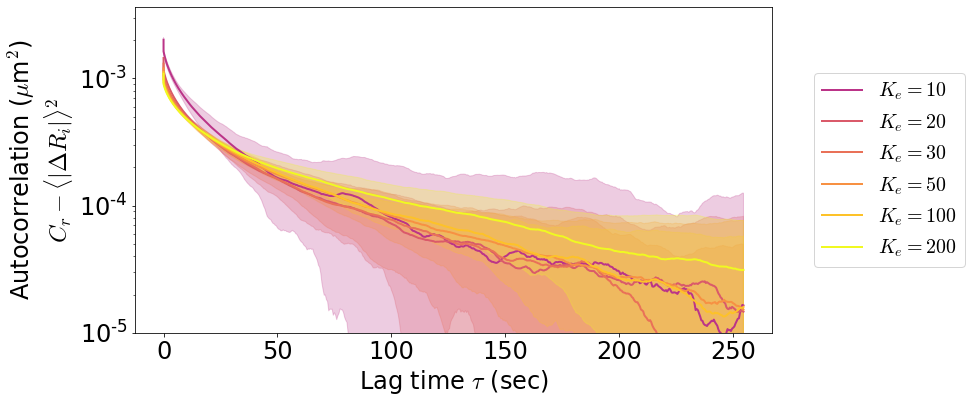

In [22]:
data_path = (ceph_path /"CondCharPaper/22-08-12_aLchr1_scan6.4_line800_sticky55nm_eps1_5um_Ke5-200/simulations")
ss_ind = -1023
end_ind = -1
start_bead = 0
end_bead = None
try:
    fig1, axarr1 = plt.subplots(1, 1, figsize=(14, 6))
    mp = re.compile('Ke(\d*\.?\d+)')

    param_dirs = sorted([pd for pd in data_path.glob('*/')],key=lambda x: float(mp.match(str(x.name))[1]))
    param_vals = [float(mp.match(str(pd.name))[1]) for pd in param_dirs]
    log_pvs = np.log10(param_vals)
    log_pvs = (log_pvs-log_pvs.min())/((log_pvs.max() - log_pvs.min()))
    colors = pl.cm.plasma(log_pvs)
    avg_auto_corr_list = []
    std_auto_corr_list = []
    for i, pd in tqdm(enumerate(param_dirs)):
        auto_corr_list = []
        sd_h5_data_lst = []
        for h5p in pd.glob('s*/analysis/raw*.h5'):
            try:
                sd_h5_data_lst+=[h5py.File(h5p, 'r')]   
            except:
                print(f'Could not open {h5p}.')
        if len(sd_h5_data_lst) == 0:
            continue
        label = re.split(r'(^[^\d]+)',str(pd.name))[1:][1]
        if i < 2:
            continue
        for h5_data in sd_h5_data_lst:
            valid_n = int((-ss_ind+end_ind)/2)
            lag_arr = h5_data['time'][:valid_n]
            sy_dat = h5_data['raw_data']['sylinders'][start_bead:end_bead,
                                                      :, ss_ind:end_ind]
            com_arr = .5 * (sy_dat[:, 2:5, :] + sy_dat[:, 5:8, :])
            avg_dist = avg_dist_from_poly_com(com_arr)
            n_beads = com_arr.shape[0]
            auto_corr_list += [poly_dist_autocorr_fast(com_arr)[:valid_n]-(avg_dist.mean()**2)]
        min_length = min([len(avg) for avg in auto_corr_list])
        auto_corr_mat = torch.stack([avg[:min_length] for avg in auto_corr_list])
        
        avg_auto_corr_list += [auto_corr_mat.mean(dim=0).cpu()]
        std_auto_corr_list += [auto_corr_mat.std(dim=0).cpu()]
        
        for h5d in sd_h5_data_lst:
            h5d.close()
    
        _ = axarr1.plot(lag_arr[:min_length], avg_auto_corr_list[-1], color=colors[i], label=f"$ K_e = {label}$")
        ci = (std_auto_corr_list[-1]/np.sqrt(len(avg_auto_corr_list)))* (np.sqrt(2)*erfinv(.95)) # 95% confidence interval
        _ = axarr1.fill_between(lag_arr[:min_length], (avg_auto_corr_list[-1] - ci), (avg_auto_corr_list[-1] + ci),color=colors[i], alpha=.25)

    _ = axarr1.set_ylabel('Autocorrelation ($\mu$m$^2$)\n' + r'$C_r - \langle |\Delta R_i| \rangle^2$')
    _ = axarr1.set_xlabel(r'Lag time $\tau$ (sec)')
    _ = axarr1.set_yscale('log')
    # _ = axarr1.set_xscale('log')
    _ = axarr1.set_ylim(0.00001)

    _ = axarr1.legend(loc='center left', bbox_to_anchor=(1.05, .5))
    fig1.tight_layout()

except:
    raise
finally:
    for h5d in sd_h5_data_lst:
        h5d.close()

0it [00:00, ?it/s]

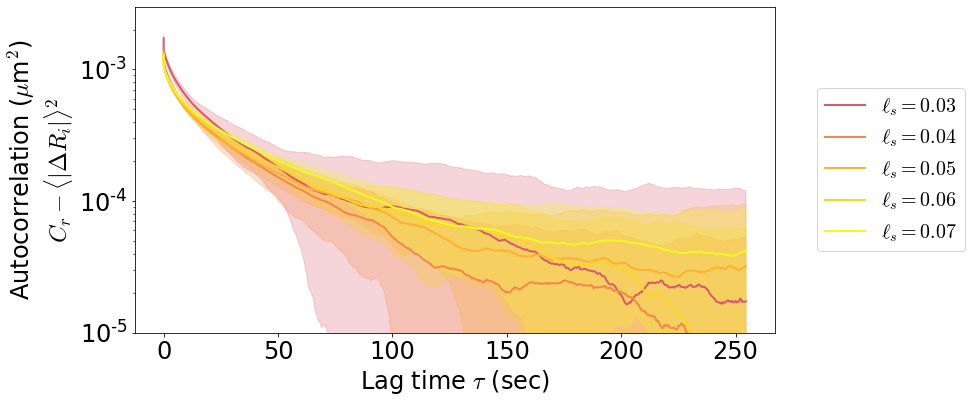

In [23]:
data_path = ceph_path / "CondCharPaper/22-10-18_aLchr1_scan7.12_Ke30_kod3.05_line800_stickyL.01-.07/simulations"
ss_ind = -1023
end_ind = -1
start_bead = 0
end_bead = None
try:
    fig1, axarr1 = plt.subplots(1, 1, figsize=(14, 6))
    mp = re.compile('Ls(\d*\.?\d+)')

    param_dirs = sorted([pd for pd in data_path.glob('*/')],key=lambda x: float(mp.match(str(x.name))[1]))
    param_vals = [float(mp.match(str(pd.name))[1]) for pd in param_dirs]
    log_pvs = np.log10(param_vals)
    log_pvs = (log_pvs-log_pvs.min())/((log_pvs.max() - log_pvs.min()))
    colors = pl.cm.plasma(log_pvs)
    avg_auto_corr_list = []
    std_auto_corr_list = []
    for i, pd in tqdm(enumerate(param_dirs)):
        auto_corr_list = []
        sd_h5_data_lst = []
        for h5p in pd.glob('s*/analysis/raw*.h5'):
            try:
                sd_h5_data_lst+=[h5py.File(h5p, 'r')]   
            except:
                print(f'Could not open {h5p}.')
        if len(sd_h5_data_lst) == 0:
            continue
        label = re.split(r'(^[^\d]+)',str(pd.name))[1:][1]
        if i < 2:
            continue
        for h5_data in sd_h5_data_lst:
            valid_n = int((-ss_ind+end_ind)/2)
            lag_arr = h5_data['time'][:valid_n]
            sy_dat = h5_data['raw_data']['sylinders'][start_bead:end_bead,
                                                      :, ss_ind:end_ind]
            com_arr = .5 * (sy_dat[:, 2:5, :] + sy_dat[:, 5:8, :])
            avg_dist = avg_dist_from_poly_com(com_arr)
            n_beads = com_arr.shape[0]
            auto_corr_list += [poly_dist_autocorr_fast(com_arr)[:valid_n]-(avg_dist.mean()**2)]
        min_length = min([len(avg) for avg in auto_corr_list])
        auto_corr_mat = torch.stack([avg[:min_length] for avg in auto_corr_list])
        
        avg_auto_corr_list += [auto_corr_mat.mean(dim=0).cpu()]
        std_auto_corr_list += [auto_corr_mat.std(dim=0).cpu()]
        
        for h5d in sd_h5_data_lst:
            h5d.close()
    
        _ = axarr1.plot(lag_arr[:min_length], avg_auto_corr_list[-1], color=colors[i], label=f"$ \ell_s = {label}$")
        ci = (std_auto_corr_list[-1]/np.sqrt(len(avg_auto_corr_list)))* (np.sqrt(2)*erfinv(.95)) # 95% confidence interval
        _ = axarr1.fill_between(lag_arr[:min_length], (avg_auto_corr_list[-1] - ci), (avg_auto_corr_list[-1] + ci),color=colors[i], alpha=.25)

    _ = axarr1.set_ylabel('Autocorrelation ($\mu$m$^2$)\n' + r'$C_r - \langle |\Delta R_i| \rangle^2$')
    _ = axarr1.set_xlabel(r'Lag time $\tau$ (sec)')
    _ = axarr1.set_yscale('log')
    # _ = axarr1.set_xscale('log')
    _ = axarr1.set_ylim(0.00001)

    _ = axarr1.legend(loc='center left', bbox_to_anchor=(1.05, .5))
    fig1.tight_layout()

except:
    raise
finally:
    for h5d in sd_h5_data_lst:
        h5d.close()

0it [00:00, ?it/s]

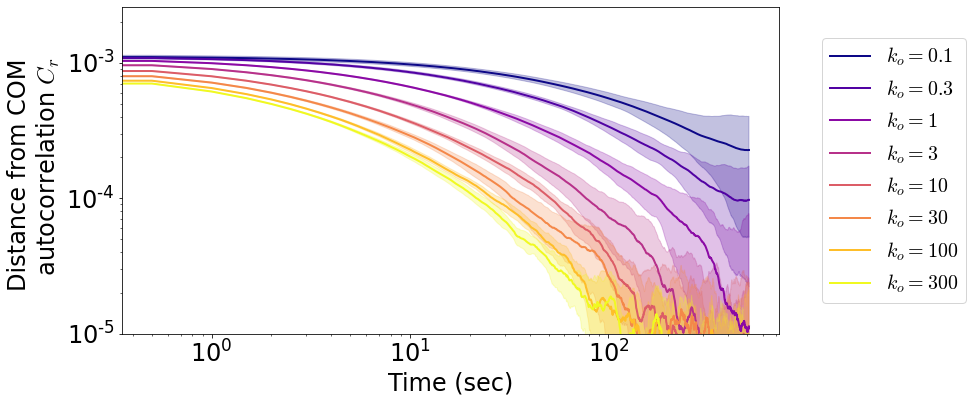

In [46]:
data_path = (ceph_path /"CondCharPaper/22-10-16_aLc1_line800_sticky55nm_kod.1-300/simulations")
ss_ind = -2047
end_ind = -1
start_bead = 0
end_bead = None
try:
    fig1, axarr1 = plt.subplots(1, 1, figsize=(14, 6))
    mp = re.compile('kod(\d*\.?\d+)')

    param_dirs = sorted([pd for pd in data_path.glob('*/')],key=lambda x: float(mp.match(str(x.name))[1]))
    param_vals = [float(mp.match(str(pd.name))[1]) for pd in param_dirs]
    log_pvs = np.log10(param_vals)
    log_pvs = (log_pvs-log_pvs.min())/((log_pvs.max() - log_pvs.min()))
    colors = pl.cm.plasma(log_pvs)
    avg_auto_corr_list = []
    std_auto_corr_list = []
    for i, pd in tqdm(enumerate(param_dirs)):
        auto_corr_list = []
        sd_h5_data_lst = [h5py.File(h5p, 'r+') for h5p in pd.glob('s*/analysis/raw*.h5')]
        if len(sd_h5_data_lst) == 0:
            continue

        for h5_data in sd_h5_data_lst:
            valid_n = int((-ss_ind+end_ind)/2)
            lag_arr = h5_data['time'][:valid_n]
            sy_dat = h5_data['raw_data']['sylinders'][start_bead:end_bead,
                                                      :, ss_ind:end_ind]
            com_arr = .5 * (sy_dat[:, 2:5, :] + sy_dat[:, 5:8, :])
            avg_dist = avg_dist_from_poly_com(com_arr)
            n_beads = com_arr.shape[0]
            auto_corr_list += [poly_dist_autocorr_fast(com_arr)[:valid_n]-(avg_dist.mean()**2)]
        min_length = min([len(avg) for avg in auto_corr_list])
        auto_corr_mat = torch.stack([avg[:min_length] for avg in auto_corr_list])
        
        avg_auto_corr_list += [auto_corr_mat.mean(dim=0).cpu()]
        std_auto_corr_list += [auto_corr_mat.std(dim=0).cpu()]
        
        label = re.split(r'(^[^\d]+)',str(pd.name))[1:][1]
        for h5d in sd_h5_data_lst:
            h5d.close()
    
        _ = axarr1.plot(lag_arr[:min_length], avg_auto_corr_list[-1], color=colors[i], label=f"$ k_o = {label}$")
        ci = (std_auto_corr_list[-1]/np.sqrt(len(avg_auto_corr_list)))* (np.sqrt(2)*erfinv(.95)) # 95% confidence interval
        _ = axarr1.fill_between(lag_arr[:min_length], (avg_auto_corr_list[-1] - ci), (avg_auto_corr_list[-1] + ci),color=colors[i], alpha=.25)

    _ = axarr1.set_ylabel('Distance from COM \n autocorrelation ' + r'$C_r$')
    _ = axarr1.set_xlabel('Time (sec)')
    _ = axarr1.set_xlabel('Time (sec)')
    _ = axarr1.set_yscale('log')
    _ = axarr1.set_xscale('log')
    _ = axarr1.set_ylim(0.00001)

    _ = axarr1.legend(loc='center left', bbox_to_anchor=(1.05, .5))
    fig1.tight_layout()

except:
    raise
finally:
    for h5d in sd_h5_data_lst:
        h5d.close()

# Conclusions and Next Steps

0.4772498680518208